# Preparation
Let us first do some preparatory steps by importing necessary libraries and loading the dataset

In [ ]:
# Import libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Load the dataset
df_playstore = pd.read_csv("/content/drive/MyDrive/Datasets/googleplaystore.csv", na_values=np.nan, encoding="utf-8")
# Remove all "Varies with device" values
df_playstore = df_playstore.replace("Varies with device", np.nan)
# Shuffle rows
df_playstore = df_playstore.sample(frac=1)
df_playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9501,Racing Moto,GAME,4.3,697805,7.4M,"50,000,000+",Free,0,Everyone,Racing,"July 3, 2018",1.2.13,3.0 and up
3235,Google Translate,TOOLS,4.4,5745093,NaN,"500,000,000+",Free,0,Everyone,Tools,"August 4, 2018",NaN,NaN
8554,Daily DM,PERSONALIZATION,4.7,51,259k,"1,000+",Free,0,Everyone,Personalization,"October 4, 2013",1,2.1 and up
2172,World Racers family board game,FAMILY,4.8,4,42M,100+,Paid,$0.99,Everyone,Board;Pretend Play,"September 3, 2015",1.1,5.1 and up
3862,Yandex.Trains,MAPS_AND_NAVIGATION,4.4,56471,NaN,"5,000,000+",Free,0,Everyone,Maps & Navigation,"July 31, 2018",NaN,NaN


# Clean data

To clean the dataset, few steps should be done:

*   Remove the duplicate rows that may cause data leakage
*   Fill in the single missing value for Type
*   Remove unit in Size and convert them to the same measurement
*   Remove symbols (',' and '+') on the Installs variable
*   Remove currency on Price
*   Remove rows with missing Content Rating

Note: Row 10472 was manually shifted in the CSV file.

In [ ]:
def reindex(df):
  # Remove duplicate rows based on App variable
  df.drop_duplicates(subset='App', keep="first", inplace=True)

  # Set App column as row index
  df = df.set_index('App')

  return df

df_playstore_reindexed = reindex(df_playstore.copy()) 
df_playstore_reindexed.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
App,,,,,,,,,,,,
Racing Moto,GAME,4.3,697805,7.4M,"50,000,000+",Free,0,Everyone,Racing,"July 3, 2018",1.2.13,3.0 and up
Google Translate,TOOLS,4.4,5745093,NaN,"500,000,000+",Free,0,Everyone,Tools,"August 4, 2018",NaN,NaN
Daily DM,PERSONALIZATION,4.7,51,259k,"1,000+",Free,0,Everyone,Personalization,"October 4, 2013",1,2.1 and up
World Racers family board game,FAMILY,4.8,4,42M,100+,Paid,$0.99,Everyone,Board;Pretend Play,"September 3, 2015",1.1,5.1 and up
Yandex.Trains,MAPS_AND_NAVIGATION,4.4,56471,NaN,"5,000,000+",Free,0,Everyone,Maps & Navigation,"July 31, 2018",NaN,NaN


In [ ]:
def clean_df(df):
  # Type only has 1 missing value, we can derive its value based on the
  # price of the sample which is 0
  df['Type'] = df['Type'].map(lambda x: 'Free' if pd.isna(x) else x)

  # Remove the unit and convert Size into the same measurement
  df['Size'] = df['Size'].map(lambda x: str(x).rstrip('M'))
  df['Size'] = df['Size'].map(lambda x: str(round((float(x.rstrip('k'))/1024), 1)) if x[-1]=='k' else x)
  df['Size'] = df['Size'].astype('float')

  # Remove the symbols in Installs
  df['Installs'] = df['Installs'].map(lambda x: str(x).rstrip('+'))
  df['Installs'] = df['Installs'].map(lambda x: ''.join(x.split(',')))
  df['Installs'] = df['Installs'].astype('int64')

  # Remove currency on Price
  df['Price'] = df['Price'].map(lambda x: x.lstrip('$').rstrip())
  df['Price'] = df['Price'].astype('float64')

  # Remove rows with missing values for Content Rating
  df.dropna(axis=0, subset=['Content Rating'], inplace=True)

  # Set Reviews dtype to int64
  df['Reviews'] = df['Reviews'].astype('int64')

  return df

df_playstore_cleaned = clean_df(df_playstore_reindexed.copy())
df_playstore_cleaned.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
App,,,,,,,,,,,,
Racing Moto,GAME,4.3,697805,7.4,50000000,Free,0.00,Everyone,Racing,"July 3, 2018",1.2.13,3.0 and up
Google Translate,TOOLS,4.4,5745093,NaN,500000000,Free,0.00,Everyone,Tools,"August 4, 2018",NaN,NaN
Daily DM,PERSONALIZATION,4.7,51,0.3,1000,Free,0.00,Everyone,Personalization,"October 4, 2013",1,2.1 and up
World Racers family board game,FAMILY,4.8,4,42.0,100,Paid,0.99,Everyone,Board;Pretend Play,"September 3, 2015",1.1,5.1 and up
Yandex.Trains,MAPS_AND_NAVIGATION,4.4,56471,NaN,5000000,Free,0.00,Everyone,Maps & Navigation,"July 31, 2018",NaN,NaN


We would need to prepare the dataset for imputation by encoding categorical data to numeric

In [ ]:
from sklearn import preprocessing

def label_encode(series):
  # Create label encoder
  lblEncoder = preprocessing.LabelEncoder()
  return lblEncoder.fit_transform(series)

def truncate_ver(x):
  matches = re.findall('[0-9]\.[0-9]|[\d]', str(x))
  if pd.isna(x) or len(matches) == 0:
    return np.nan
  else: 
    return float(matches[0])


def encode_df(df):
  # Encode categorical variables
  df['Category_Encoded'] = label_encode(df['Category'])
  df['Content_Rating_Encoded'] = label_encode(df['Content Rating'])
  df['Genres_Encoded'] = label_encode(df['Genres'])

  # Convert Date to Int
  df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
  df['Last_Updated_Int'] = df['Last Updated'].astype('int64')

  # Remove third decimal on version
  df['Current Ver'] = df['Current Ver'].apply(truncate_ver)
  df['Android Ver'] = df['Android Ver'].apply(truncate_ver)

  # Map Type
  df['Type'] = df['Type'].map(lambda x: 0 if x == "Free" else 1)

  return df

df_playstore_with_encoding = encode_df(df_playstore_cleaned.copy())
df_playstore_with_encoding.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Category_Encoded,Content_Rating_Encoded,Genres_Encoded,Last_Updated_Int
App,,,,,,,,,,,,,,,,
Racing Moto,GAME,4.3,697805,7.4,50000000,0,0.00,Everyone,Racing,2018-07-03,1.2,3.0,14,1,88,1530576000000000000
Google Translate,TOOLS,4.4,5745093,NaN,500000000,0,0.00,Everyone,Tools,2018-08-04,NaN,NaN,29,1,108,1533340800000000000
Daily DM,PERSONALIZATION,4.7,51,0.3,1000,0,0.00,Everyone,Personalization,2013-10-04,1.0,2.1,23,1,80,1380844800000000000
World Racers family board game,FAMILY,4.8,4,42.0,100,1,0.99,Everyone,Board;Pretend Play,2015-09-03,1.1,5.1,11,1,18,1441238400000000000
Yandex.Trains,MAPS_AND_NAVIGATION,4.4,56471,NaN,5000000,0,0.00,Everyone,Maps & Navigation,2018-07-31,NaN,NaN,19,1,70,1532995200000000000


Create a copy of the dataframe with categorical columns replaced with their encoded version

In [ ]:
# Drop non numeric columns
df_playstore_encoded = df_playstore_with_encoding.drop(['Category', 'Content Rating', 'Genres', 'Last Updated'], axis=1)

# Rename encoded columns
df_playstore_encoded.rename(columns={
    'Category_Encoded': 'Category',
    'Content_Rating_Encoded': 'Content Rating',
    'Genres_Encoded': 'Genres',
    'Last_Updated_Int': 'Last Updated',
}, inplace=True)

df_playstore_encoded.head()


,Rating,Reviews,Size,Installs,Type,Price,Current Ver,Android Ver,Category,Content Rating,Genres,Last Updated
App,,,,,,,,,,,,
Racing Moto,4.3,697805,7.4,50000000,0,0.00,1.2,3.0,14,1,88,1530576000000000000
Google Translate,4.4,5745093,NaN,500000000,0,0.00,NaN,NaN,29,1,108,1533340800000000000
Daily DM,4.7,51,0.3,1000,0,0.00,1.0,2.1,23,1,80,1380844800000000000
World Racers family board game,4.8,4,42.0,100,1,0.99,1.1,5.1,11,1,18,1441238400000000000
Yandex.Trains,4.4,56471,NaN,5000000,0,0.00,NaN,NaN,19,1,70,1532995200000000000


Now that we have our dataframe fully encoded. We can start using KNN Imputer to generate values for our missing values.

In [ ]:
# Confirm that we encoded all variables to numeric
df_playstore_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9660 entries, Racing Moto to MbH BP
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rating          8197 non-null   float64
 1   Reviews         9660 non-null   int64  
 2   Size            8433 non-null   float64
 3   Installs        9660 non-null   int64  
 4   Type            9660 non-null   int64  
 5   Price           9660 non-null   float64
 6   Current Ver     8580 non-null   float64
 7   Android Ver     8668 non-null   float64
 8   Category        9660 non-null   int64  
 9   Content Rating  9660 non-null   int64  
 10  Genres          9660 non-null   int64  
 11  Last Updated    9660 non-null   int64  
dtypes: float64(5), int64(7)
memory usage: 981.1+ KB


In [ ]:
from sklearn.impute import KNNImputer

# Create imputer
knn_imputer = KNNImputer(n_neighbors=25)

# Fill in missing values with imputer
imputation_result = knn_imputer.fit_transform(df_playstore_encoded)

# Put the results into a data frame
df_playstore_imputed = pd.DataFrame(imputation_result, columns=df_playstore_encoded.columns, index=df_playstore_encoded.index)
df_playstore_imputed.head()

,Rating,Reviews,Size,Installs,Type,Price,Current Ver,Android Ver,Category,Content Rating,Genres,Last Updated
App,,,,,,,,,,,,
Racing Moto,4.3,697805.0,7.400,50000000.0,0.0,0.00,1.200,3.000,14.0,1.0,88.0,1.530576e+18
Google Translate,4.4,5745093.0,21.304,500000000.0,0.0,0.00,2.928,4.268,29.0,1.0,108.0,1.533341e+18
Daily DM,4.7,51.0,0.300,1000.0,0.0,0.00,1.000,2.100,23.0,1.0,80.0,1.380845e+18
World Racers family board game,4.8,4.0,42.000,100.0,1.0,0.99,1.100,5.100,11.0,1.0,18.0,1.441238e+18
Yandex.Trains,4.4,56471.0,32.220,5000000.0,0.0,0.00,3.312,4.224,19.0,1.0,70.0,1.532995e+18


In [ ]:
# Verify if the imputed values are correct. Check if they are still within the correct range (e.g, 1-5 for Rating)
df_playstore_imputed.describe()

,Rating,Reviews,Size,Installs,Type,Price,Current Ver,Android Ver,Category,Content Rating,Genres,Last Updated
count,9660.000000,9.660000e+03,9660.000000,9.660000e+03,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9.660000e+03
mean,4.169388,2.165587e+05,20.924404,7.785521e+06,0.078054,1.097117,2.410099,3.863343,16.766563,1.436957,64.626708,1.509393e+18
std,0.497353,1.830921e+06,20.598703,5.376374e+07,0.268270,16.850750,1.730666,0.817522,8.397051,0.986953,32.607343,3.514338e+16
min,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.274400e+18
25%,4.000000,2.500000e+01,5.300000,1.000000e+03,0.000000,0.000000,1.100000,4.000000,11.000000,1.000000,39.000000,1.501956e+18
50%,4.208000,9.670000e+02,15.000000,1.000000e+05,0.000000,0.000000,1.972000,4.100000,14.000000,1.000000,67.000000,1.525392e+18
75%,4.500000,2.939400e+04,29.000000,1.000000e+06,0.000000,0.000000,3.100000,4.200000,25.000000,1.000000,96.000000,1.531786e+18
max,5.000000,7.815831e+07,100.000000,1.000000e+09,1.000000,400.000000,9.900000,8.000000,32.000000,5.000000,118.000000,1.533686e+18


# **Map categorical columns back**
Things to do to get the processed to look like the original one:
*   Replace the values of the processed variables with the original ones. Excluding imputed variables: Size, Rating, Current Ver, Android Ver.
*   Format Current Ver and Android Ver to a single decimal digit
*   Format Rating to only have a single digit decimal value
*   Map Type to its categorical equivalent
*   Rename Android Ver to Minimum Android Ver to match imputed values better

In [ ]:
def revert_row(sample):
  # Map columns to their original format
  columns_to_revert = ['Category', 'Reviews', 'Installs', 'Price', 'Content Rating', 'Genres', 'Last Updated']
  for column in columns_to_revert:
    sample[column] = df_playstore_reindexed.loc[sample.name][column]
  return sample

def revert_df(df):
  df = df.apply(revert_row, axis=1)

  # Revert Type to Categorical
  df['Type'] = df['Type'].map(lambda x: 'Free' if x == 0 else 'Paid')

  # Format version number and rating to a single decimal
  df['Current Ver'] = df['Current Ver'].round(1)
  df['Android Ver'] = df['Android Ver'].round(1)
  df['Rating'] = df['Rating'].round(1)

  # Rename "Android Ver" to "Minimum Android Ver"
  df = df.rename(columns={'Android Ver': 'Minimum Android Ver'})
  return df

df_playstore_formatted = revert_df(df_playstore_imputed.copy())
df_playstore_formatted.head()

,Rating,Reviews,Size,Installs,Type,Price,Current Ver,Minimum Android Ver,Category,Content Rating,Genres,Last Updated
App,,,,,,,,,,,,
Racing Moto,4.3,697805,7.400,"50,000,000+",Free,0,1.2,3.0,GAME,Everyone,Racing,"July 3, 2018"
Google Translate,4.4,5745093,21.304,"500,000,000+",Free,0,2.9,4.3,TOOLS,Everyone,Tools,"August 4, 2018"
Daily DM,4.7,51,0.300,"1,000+",Free,0,1.0,2.1,PERSONALIZATION,Everyone,Personalization,"October 4, 2013"
World Racers family board game,4.8,4,42.000,100+,Paid,$0.99,1.1,5.1,FAMILY,Everyone,Board;Pretend Play,"September 3, 2015"
Yandex.Trains,4.4,56471,32.220,"5,000,000+",Free,0,3.3,4.2,MAPS_AND_NAVIGATION,Everyone,Maps & Navigation,"July 31, 2018"


In [ ]:
# Rearrange columns to the original order
df_playstore_final = df_playstore_formatted.reindex(columns=['Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Minimum Android Ver'])
df_playstore_final.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Minimum Android Ver
App,,,,,,,,,,,,
Racing Moto,GAME,4.3,697805,7.400,"50,000,000+",Free,0,Everyone,Racing,"July 3, 2018",1.2,3.0
Google Translate,TOOLS,4.4,5745093,21.304,"500,000,000+",Free,0,Everyone,Tools,"August 4, 2018",2.9,4.3
Daily DM,PERSONALIZATION,4.7,51,0.300,"1,000+",Free,0,Everyone,Personalization,"October 4, 2013",1.0,2.1
World Racers family board game,FAMILY,4.8,4,42.000,100+,Paid,$0.99,Everyone,Board;Pretend Play,"September 3, 2015",1.1,5.1
Yandex.Trains,MAPS_AND_NAVIGATION,4.4,56471,32.220,"5,000,000+",Free,0,Everyone,Maps & Navigation,"July 31, 2018",3.3,4.2


In [ ]:
# Look at the overview of the dataset
df_playstore_final.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,9660.0,4.169710,4.974724e-01,1.0,4.0,4.2,4.5,5.0
Reviews,9660.0,216558.686853,1.830921e+06,0.0,25.0,967.0,29394.0,78158306.0
Size,9660.0,20.924404,2.059870e+01,0.0,5.3,15.0,29.0,100.0
Current Ver,9660.0,2.410062,1.730567e+00,0.0,1.1,2.0,3.1,9.9
Minimum Android Ver,9660.0,3.863499,8.175595e-01,1.0,4.0,4.1,4.2,8.0


In [ ]:
# Look at the overview of the categorical variables of the dataset
df_playstore_final[['Category', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated']].astype('object').describe().transpose()

,count,unique,top,freq
Category,9660,33,FAMILY,1873
Installs,9660,21,"1,000,000+",1417
Type,9660,2,Free,8906
Price,9660,92,0,8906
Content Rating,9660,6,Everyone,7904
Genres,9660,119,Tools,827
Last Updated,9660,1377,"August 3, 2018",252


# Explore Dataset After Cleaning

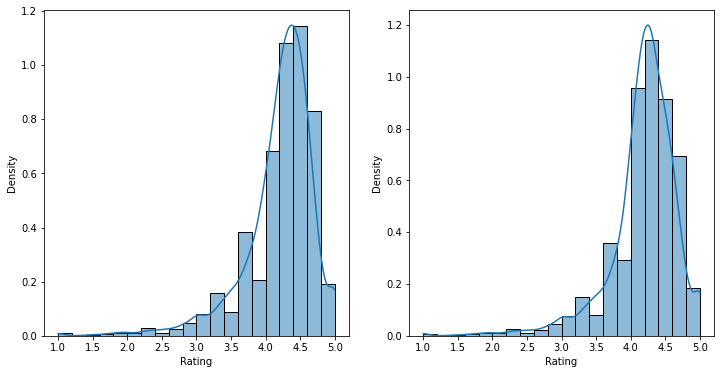

In [ ]:
from scipy.stats import norm

fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.histplot(df_playstore, x='Rating', stat='density', bins=20, kde=True, ax=ax[0])
sns.histplot(df_playstore_imputed, stat='density', x='Rating', bins=20, kde=True, ax=ax[1])

# Export processed dataset

In [ ]:
df_playstore_export = df_playstore_final.reset_index()
df_playstore_export.to_csv('cleaned_googleplaystore.csv', index=False)

# References
https://medium.com/the-research-nest/data-science-tutorial-analysis-of-the-google-play-store-dataset-c720330d4903
https://www.researchgate.net/publication/341370060_KNN_Imputation_Missing_Value_For_Predictor_App_Rating_on_Google_Play_Using_Random_Forest_Method